In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=619641 sha256=e490582e63f76e9ff58bd49d2af0854a370e6c8295e359916aca09afd3618749
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

# torch
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp

# kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

# transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/네이버 영화 리뷰

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/네이버 영화 리뷰


### 데이터 전처리

In [ ]:
data = pd.read_csv('./네이버 영화 리뷰.csv')

In [ ]:
# 9-10 : 4(매우 만족)
# 7-8 : 3(만족)
# 5-6 : 2(보통)
# 3-4 : 1(불만족)
# 1-2 : 0(매우불만족)

data['만족도'] = data['score'].map(lambda x: 4 if x > 8 else 3 if x > 6 else 2 if x > 4 else 1 if x > 2 else 0)
# data['score'] = data['score'].map(lambda x: x-1)
data['sentence'] = data['sentence'].fillna('')

In [ ]:
data.head()

,score,sentence,id,date,heart,hate,만족도
0,10,CG에 돈 많이 썼다는건 개구라임. 다만 직접 판도라가서 수중촬영하긴 빡쎘을거 같음...,archijun(arch****),2022.12.15 17:14,12445,920,4
1,10,말이안되네 ㅋㅋㅋ 어케만든겨,은덕(dmse****),2022.12.14 11:33,4270,251,4
2,10,제일궁금했던건 2009년도에도 대단했던 CG기술이 2022년도에 얼마나 대단해졌을까...,hwle****,2022.12.14 10:51,4050,349,4
3,10,미래에도 영화관이 있어야 되는 이유를 보여준 영화.,버츠비이이이(ydg3****),2022.12.14 13:23,3806,216,4
4,10,믿고보는 아바타 아쿠아리움에 있는줄..3시간이 어떻게 간건지 모르겠어요,nice****,2022.12.14 13:08,2853,205,4


### 데이터 분할

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['sentence'],data['만족도'], test_size=0.25, stratify=data['만족도'],random_state=42)

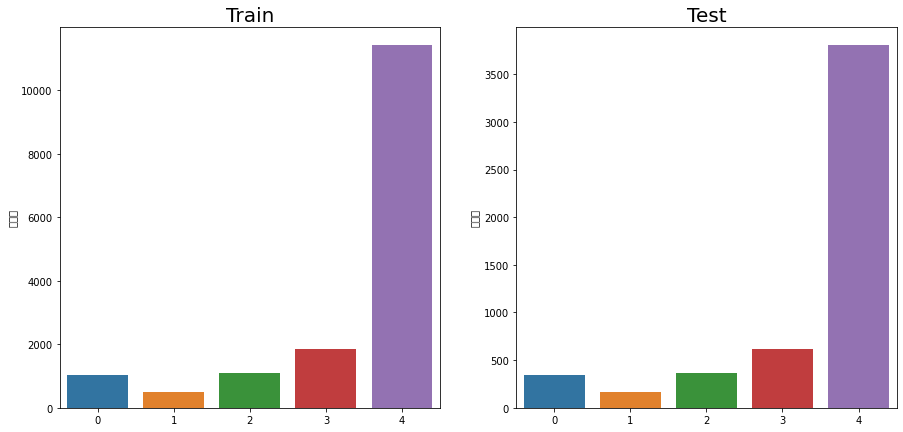

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(x=y_train.value_counts().index  , y=y_train.value_counts())
plt.title('Train',size=20)

plt.subplot(1,2,2)
sns.barplot(x=y_test.value_counts().index  , y=y_test.value_counts())
plt.title('Test',size=20)

plt.show()

### Bert dataset 생성

In [ ]:
def bert_preprocessing(input,target):
  review_list = []
  for review, label in zip(input,target):
    review_list.append([review,str(label)])
  return review_list

In [ ]:
train = bert_preprocessing(X_train,y_train)
test = bert_preprocessing(X_test,y_test)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
max_len = 128
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

bert_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
bert_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

using cached model. /content/drive/MyDrive/네이버 영화 리뷰/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
train_dataloader = torch.utils.data.DataLoader(bert_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(bert_test, batch_size=batch_size, num_workers=5)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
class_count = data.groupby(['만족도'])['id'].count().values
df_count = len(data)
class_weight = df_count/class_count

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

def calc_metric(out,label):
    max_vals = torch.argmax(out, 1)
    train_acc = (max_vals == label).sum().data.cpu().numpy()/df_count
    train_p = np.zeros(len(class_weight))
    train_r = np.zeros(len(class_weight))
    for i,j in zip(max_vals,label):
      if i==j:
        train_p[i] += 1
        train_r[i] += 1

    p_count = np.bincount(max_vals.to('cpu').detach().numpy(),minlength=len(class_weight))
    r_count = np.bincount(label.to('cpu').detach().numpy(),minlength=len(class_weight))
    return train_acc, train_p, train_r, p_count, r_count

def cal_f1_score(train_p,train_r,p_count,r_count):
  precision = np.mean(train_p/(p_count+0.0001))
  recall = np.mean(train_r/(r_count+0.0001))
  return 2*precision*recall/(precision+recall)

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    train_f1 = 0.0
    test_acc = 0.0
    test_f1 = 0.0

    train_p = np.zeros(len(class_weight))
    train_r = np.zeros(len(class_weight))
    test_p = np.zeros(len(class_weight))
    test_r = np.zeros(len(class_weight))
    train_p_count = np.zeros(len(class_weight))
    train_r_count = np.zeros(len(class_weight))
    test_p_count = np.zeros(len(class_weight))
    test_r_count = np.zeros(len(class_weight))

    
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)

        # f1_score
        acc,p,r,p_c,p_r = calc_metric(out, label)
        train_acc += acc
        train_p += p
        train_r += r
        train_p_count = train_p_count + p_c
        train_r_count = train_r_count + p_r

        train_f1 = cal_f1_score(train_p,train_r,train_p_count,train_r_count)

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {} train f1 {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1), train_f1))
            for j in range(len(class_weight)):
              print(f'star {j+1} metric : precision {np.round(train_p[j]/(train_p_count[j]+0.0001),4)}, recall {np.round(train_r[j]/(train_r_count[j]+0.0001),4)} ')

    print("epoch {} train acc {} train f1 {}".format(e+1, train_acc / (batch_id+1), train_f1))
    
    # test
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

        acc,p,r,p_c,p_r = calc_metric(out, label)
        test_acc += acc
        test_p += p
        test_r += r
        test_p_count = test_p_count + p_c
        test_r_count = test_r_count + p_r
        
        test_f1 = cal_f1_score(test_p,test_r,test_p_count,test_r_count)

        
    for j in range(len(class_weight)):
      print(f'star {j+1} metric : precision {np.round(test_p[j]/(test_p_count[j]+0.0001),4)}, recall {np.round(test_r[j]/(test_r_count[j]+0.0001),4)} ')

    print("epoch {} test acc {} test f1 {}".format(e+1, test_acc / (batch_id+1), test_f1))

  0%|          | 0/249 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.7958652973175049 train acc 0.06268882175226587 train f1 0.029629519890667064
star 1 metric : precision 0.0, recall 0.0 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.0, recall 0.0 
star 4 metric : precision 0.0, recall 0.0 
star 5 metric : precision 0.6667, recall 0.0833 
epoch 1 batch id 201 loss 0.7770844101905823 train acc 0.6711758428401796 train f1 0.26723927639994527
star 1 metric : precision 0.173, recall 0.143 
star 2 metric : precision 0.051, recall 0.0466 
star 3 metric : precision 0.1894, recall 0.09 
star 4 metric : precision 0.2411, recall 0.0887 
star 5 metric : precision 0.7624, recall 0.8958 
epoch 1 train acc 0.6891908646671279 train f1 0.28790963388992236


  0%|          | 0/83 [00:00<?, ?it/s]

star 1 metric : precision 0.5638, recall 0.3937 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.3201, recall 0.4617 
star 4 metric : precision 0.435, recall 0.2649 
star 5 metric : precision 0.8676, recall 0.9466 
epoch 1 test acc 0.7703864931023185 test f1 0.425013884704275


  0%|          | 0/249 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6190828084945679 train acc 0.7992824773413897 train f1 0.392150652838703
star 1 metric : precision 0.0, recall 0.0 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.5, recall 1.0 
star 4 metric : precision 0.5, recall 0.125 
star 5 metric : precision 0.8519, recall 0.9583 
epoch 2 batch id 201 loss 0.60007244348526 train acc 0.7766708376546273 train f1 0.42592635212904373
star 1 metric : precision 0.4555, recall 0.4865 
star 2 metric : precision 0.1786, recall 0.013 
star 3 metric : precision 0.3447, recall 0.2301 
star 4 metric : precision 0.4489, recall 0.2979 
star 5 metric : precision 0.8606, recall 0.9641 
epoch 2 train acc 0.7848605524818308 train f1 0.4412195049585879


  0%|          | 0/83 [00:00<?, ?it/s]

star 1 metric : precision 0.4963, recall 0.5805 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.3732, recall 0.3497 
star 4 metric : precision 0.4496, recall 0.2956 
star 5 metric : precision 0.8763, recall 0.954 
epoch 2 test acc 0.783730086509179 test f1 0.4375162170974511


  0%|          | 0/249 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.4318782389163971 train acc 0.8306268882175226 train f1 0.4887245179562356
star 1 metric : precision 0.4, recall 0.5 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.4, recall 0.5 
star 4 metric : precision 1.0, recall 0.25 
star 5 metric : precision 0.9038, recall 0.9792 
epoch 3 batch id 201 loss 0.4805104434490204 train acc 0.8107442395274382 train f1 0.4956156345669519
star 1 metric : precision 0.5301, recall 0.619 
star 2 metric : precision 0.2353, recall 0.0104 
star 3 metric : precision 0.4111, recall 0.3451 
star 4 metric : precision 0.5221, recall 0.4237 
star 5 metric : precision 0.9031, recall 0.9674 
epoch 3 train acc 0.8179043591283564 train f1 0.5062224619006326


  0%|          | 0/83 [00:00<?, ?it/s]

star 1 metric : precision 0.5573, recall 0.5172 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.3414, recall 0.347 
star 4 metric : precision 0.4337, recall 0.3118 
star 5 metric : precision 0.8763, recall 0.9579 
epoch 3 test acc 0.7841077300137107 test f1 0.434136299194128


  0%|          | 0/249 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.35238730907440186 train acc 0.8933157099697885 train f1 0.611484293104806
star 1 metric : precision 0.6, recall 0.75 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.6, recall 0.75 
star 4 metric : precision 1.0, recall 0.5 
star 5 metric : precision 0.94, recall 0.9792 
epoch 4 batch id 201 loss 0.42791473865509033 train acc 0.8491840269949344 train f1 0.5801317115422125
star 1 metric : precision 0.6076, recall 0.7116 
star 2 metric : precision 0.36, recall 0.0233 
star 3 metric : precision 0.4956, recall 0.5171 
star 4 metric : precision 0.6373, recall 0.5508 
star 5 metric : precision 0.9352, recall 0.9743 
epoch 4 train acc 0.8547240320799819 train f1 0.5906230600921878


  0%|          | 0/83 [00:00<?, ?it/s]

star 1 metric : precision 0.483, recall 0.6121 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.3477, recall 0.3743 
star 4 metric : precision 0.4305, recall 0.315 
star 5 metric : precision 0.8902, recall 0.9385 
epoch 4 test acc 0.7786318991980005 test f1 0.43894725330815787


  0%|          | 0/249 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.2988133132457733 train acc 0.908987915407855 train f1 0.6583256329559244
star 1 metric : precision 0.75, recall 0.75 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.6667, recall 1.0 
star 4 metric : precision 1.0, recall 0.5 
star 5 metric : precision 0.94, recall 0.9792 
epoch 5 batch id 201 loss 0.3570895195007324 train acc 0.8831014865250789 train f1 0.6438265840014281
star 1 metric : precision 0.6987, recall 0.7937 
star 2 metric : precision 0.36, recall 0.0233 
star 3 metric : precision 0.5754, recall 0.656 
star 4 metric : precision 0.7402, recall 0.663 
star 5 metric : precision 0.9528, recall 0.982 
epoch 5 train acc 0.8862572647083808 train f1 0.644584212738916


  0%|          | 0/83 [00:00<?, ?it/s]

star 1 metric : precision 0.5424, recall 0.5144 
star 2 metric : precision 0.0, recall 0.0 
star 3 metric : precision 0.3476, recall 0.3552 
star 4 metric : precision 0.3984, recall 0.3958 
star 5 metric : precision 0.8941, recall 0.9353 
epoch 5 test acc 0.7781281849452187 test f1 0.43831134742084615


In [ ]:
torch.cuda.empty_cache()